<a href="https://colab.research.google.com/github/kotekjedi/GANs-ITMO-2022-Masters/blob/main/Assignment%202/2_cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**ITMO University, Autumn 2022, MSc course**


## Assignment 2


***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


Let's continue our dive into the classical generative models! Today's goal is to implement Conditional GAN for the MNIST dataset. There will be no particular instructions how to do it (just a few checkpoints) - feel free to rewrite this skeleton or reuse your code from the previous assignment.

Good luck!


## 1. Conditional GAN
*Source: <a href="https://arxiv.org/pdf/1411.1784.pdf" target="_blank">Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014)</a>.*

### Imports

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.display import Image
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image
from datetime import datetime

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

%matplotlib inline
plt.style.use("ggplot")

### Some parameters


In [2]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda" if torch.cuda.is_available() else "cpu"
number_class = 10

if device == "cuda":
    !nvidia-smi

sample_dir = "./images"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Wed Nov 30 20:51:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   37C    P0    N/A /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load dataset and create dataloader

In [3]:
# Your code here!

# mnist = MNIST(...) # don't forget to normalize data
mnist = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

# dataloader = ...
data_loader = torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=True)


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw




Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw




Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw




Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [4]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label:  5
Label: 5


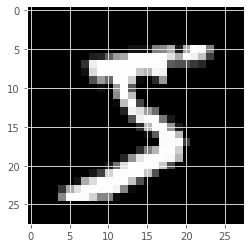

In [5]:
# Let's plot something

img, label = mnist[0]
print("Label: ", label)

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap="gray")
print("Label:", label)

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([0.        , 0.06614379, 0.13228758, 0.19843137, 0.26457515,
        0.33071896, 0.39686275, 0.46300653, 0.5291503 , 0.5952941 ,
        0.6614379 , 0.7275817 , 0.7937255 , 0.8598693 , 0.92601305,
        0.99215686], dtype=float32),
 <a list of 100 BarContainer objects>)

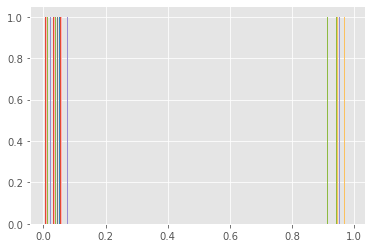

In [6]:
plt.hist(img_norm[:, 5:15, 5:15].flatten(), bins=15)

### Define the models

Define the Discriminator network, the Generator network with additional input for condition

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size, num_class): 
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_class, num_class) 

        # you may find useful to pass number_class and use nn.Embedding here
        # Architecture suggestion: linear1 - relu - linear2 - relu - linear3 - tanh

        self.fc1 = nn.Linear(latent_size + num_class, hidden_size)
        self.activ1 = nn.ReLU()

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.activ2 = nn.ReLU()

        self.fc3 = nn.Linear(hidden_size, image_size)
        self.activ3 = nn.Tanh()
            

    def forward(self, x, labels): # you may find useful to pass label here
        # Concatenate label embedding and image to produce input
        x_input = torch.cat((self.label_emb(labels), x), -1)
        
        x = self.fc1(x_input)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        x = self.activ3(x)

        return x


class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size, num_class): 
        # you may find useful to pass number_class and use nn.Embedding here
        # Architecture suggestion: linear1 - leaky_relu - linear2 - leaky_relu - linear3 - sigmoid
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_class, num_class)
        
        self.fc1 = nn.Linear(image_size+num_class, hidden_size)
        self.activ1 = nn.LeakyReLU()
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.activ2 = nn.LeakyReLU()
        
        self.fc3 = nn.Linear(hidden_size, 1)
        self.sm = nn.Sigmoid()

    def forward(self, x, labels):
        d_in = torch.cat((x.view(x.size(0), -1), self.label_embedding(labels)), -1)
        x = self.fc1(d_in)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        x = self.sm(x)
        return x

In [9]:
G = Generator(latent_size, image_size, hidden_size, number_class)
D = Discriminator(image_size, hidden_size, number_class)

In [10]:
# Let's define loss and optimizers

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=LR)
g_optimizer = torch.optim.Adam(G.parameters(), lr=LR)

### Discriminator Training

In [11]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


def train_discriminator(D_model, G_model, images, labels, device=device, batch_size=batch_size, latent_size=latent_size):

    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    gen_labels = torch.cuda.IntTensor(np.random.randint(0, number_class, batch_size)).to(device)
    # Loss for real images

    outputs = D_model(images, labels)
    loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images

    #z = torch.randn(batch_size, latent_size).to(device)
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    fake_images = G_model(z, gen_labels)
    outputs = D_model(fake_images, gen_labels)
    
    loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = (loss_real + loss_fake)/2

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    d_optimizer.step()
    
    # Reset gradients
    reset_grad()

    return d_loss, real_score, fake_score

### Generator Training

In [12]:
def train_generator(D_model, G_model, device=device, batch_size=batch_size, latent_size=latent_size):
    # Generate fake images and calculate loss
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    gen_labels = torch.cuda.IntTensor(np.random.randint(0, number_class, batch_size)).to(device)

    fake_images = G_model(z, gen_labels)
    labels = torch.ones(batch_size, 1).to(device)
    
    # calculate the generator loss
    g_loss = criterion(D_model(fake_images, gen_labels), labels)
    
    # Backprop and optimize
    
    g_loss.backward()
    g_optimizer.step()
    
    # Reset gradients
    
    reset_grad()

    return g_loss, fake_images

### Start the training proccess

In [13]:
def save_fake_images(G_model, index, sample_dir=sample_dir, device=device, batch_size=batch_size, 
                           latent_size=latent_size):
    # sample several (e.g. batch_size) random vectors and random class numbers for the generator
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    gen_labels = torch.cuda.IntTensor(np.random.randint(0, number_class, batch_size)).to(device)
    
    fake_images = G_model(sample_vectors, gen_labels)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)


    # save images
    fake_name = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_name)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_name), nrow=10)

In [30]:
%%time
print(f"[{datetime.now()}] -- Training started")
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)

for epoch in tqdm_notebook(range(num_epochs)):
    for i, (images, digit) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        digit = digit.to(device)
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(D, G, images, digit)
        
        g_loss, fake_images = train_generator(D, G)

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "[{}] -- Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    datetime.now(),
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images(G, epoch + 1)

[2022-11-30 20:55:33.274244] -- Training started


[2022-11-30 20:55:39.001607] -- Epoch [0/300], Step [200/600], d_loss: 0.4152, g_loss: 2.9782, D(x): 0.76, D(G(z)): 0.28
[2022-11-30 20:55:44.322926] -- Epoch [0/300], Step [400/600], d_loss: 0.1175, g_loss: 3.1773, D(x): 0.91, D(G(z)): 0.09
[2022-11-30 20:55:49.766704] -- Epoch [0/300], Step [600/600], d_loss: 0.1453, g_loss: 3.2983, D(x): 0.88, D(G(z)): 0.08
Saving fake_images-0001.png
[2022-11-30 20:55:55.277358] -- Epoch [1/300], Step [200/600], d_loss: 0.1164, g_loss: 3.1061, D(x): 0.90, D(G(z)): 0.08
[2022-11-30 20:56:00.900735] -- Epoch [1/300], Step [400/600], d_loss: 0.1063, g_loss: 3.2995, D(x): 0.95, D(G(z)): 0.13
[2022-11-30 20:56:06.189211] -- Epoch [1/300], Step [600/600], d_loss: 0.1233, g_loss: 3.6750, D(x): 0.92, D(G(z)): 0.07
Saving fake_images-0002.png
[2022-11-30 20:56:11.609317] -- Epoch [2/300], Step [200/600], d_loss: 0.2616, g_loss: 5.4909, D(x): 0.82, D(G(z)): 0.03
[2022-11-30 20:56:16.916391] -- Epoch [2/300], Step [400/600], d_loss: 0.4554, g_loss: 4.1338, D(

### Show your conditional generation results for every class

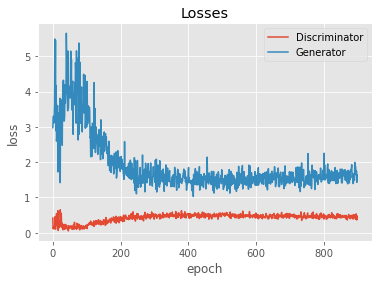

In [31]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

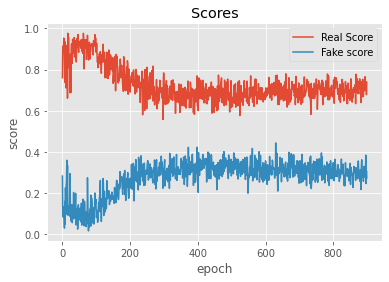

In [32]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

In [33]:
def get_generator_image(index, G_model, labels, batch_size=batch_size, latent_size=latent_size, device=device):
    
    # sample several (e.g. batch_size) random vectors and random class numbers for the generator
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    labels= labels.to(device)
    fake_images = G_model(sample_vectors, labels)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_name = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_name)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_name), nrow=10)
    return fake_images

In [14]:
n_row = 5
labels = np.array([num for _ in range(n_row) for num in range(n_row)])
labels

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
       2, 3, 4])

In [34]:
n_row = 10
labels = torch.tensor(np.array([num for _ in range(n_row) for num in range(n_row)]))
fake_images = get_generator_image(301, G, labels)

Saving fake_images-0301.png


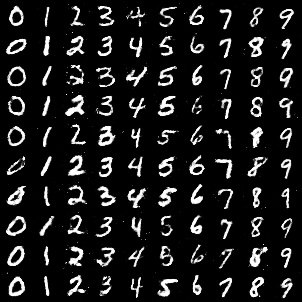

In [35]:
Image(os.path.join(sample_dir, "fake_images-0301.png"))